![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de popularidad en canción

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de popularidad en canción".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad-2025-12-prediccion-popularidad-en-cancion).

## Datos para la predicción de popularidad en cancion

En este proyecto se usará el conjunto de datos de datos de popularidad en canciones, donde cada observación representa una canción y se tienen variables como: duración de la canción, acusticidad y tempo, entre otras. El objetivo es predecir qué tan popular es la canción. Para más detalles puede visitar el siguiente enlace: [datos](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

## Ejemplo predicción conjunto de test para envío a Kaggle

En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTrain_Spotify.csv')
dataTesting = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2025/main/datasets/dataTest_Spotify.csv', index_col=0)

## Analisis preliminar de datos (EDA)

#### Contexto del problema

Se quiere crear un sistema de recomendacion basado en las preferencias del ususario. 

Se quiere clasificar las canciones en base a caracteristicas de audio y generos disponibles.

#### Variables

**track_id**: The Spotify ID for the track

**artists**: The artists' names who performed the track. If there is more than one artist, they are separated by a ;

**album_name**: The album name in which the track appears

**track_name**: Name of the track

**popularity**: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.

**duration_ms**: The track length in milliseconds

**explicit**: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)

**danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

**energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

**key**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1

**loudness**: The overall loudness of a track in decibels (dB)

**mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0

**speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks

**acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic

**instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content

**liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live

**valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)

**tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

**time_signature**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.

**track_genre**: The genre in which the track belongs

In [4]:
dataTraining.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
dataTraining.dtypes

track_id             object
artists              object
album_name           object
track_name           object
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
popularity            int64
dtype: object

In [6]:
# Memoria antes de optimización
mem_before = dataTraining.memory_usage(deep=True).sum() / 1024**2  # en MB

# Optimizar tipos de datos
for col in dataTraining.columns:
    col_type = dataTraining[col].dtype

    if col_type == 'float64':
        dataTraining[col] = dataTraining[col].astype('float32')
    elif col_type == 'int64':
        dataTraining[col] = dataTraining[col].astype('int32')
    elif col_type == 'bool':
        dataTraining[col] = dataTraining[col].astype('int8')  # más compacto
    elif col_type == 'object':
        num_unique_values = dataTraining[col].nunique()
        num_total_values = len(dataTraining[col])
        if num_unique_values / num_total_values < 0.5:
            dataTraining[col] = dataTraining[col].astype('category')

# Memoria después de optimización
mem_after = dataTraining.memory_usage(deep=True).sum() / 1024**2  # en MB

print(f'Memoria antes: {mem_before:.2f} MB')
print(f'Memoria después: {mem_after:.2f} MB')
print(f'Reducción: {100 * (mem_before - mem_after) / mem_before:.2f}%')

Memoria antes: 34.15 MB
Memoria después: 22.43 MB
Reducción: 34.33%


In [7]:
dataTraining.dtypes

track_id              object
artists             category
album_name          category
track_name            object
duration_ms            int32
explicit                int8
danceability         float32
energy               float32
key                    int32
loudness             float32
mode                   int32
speechiness          float32
acousticness         float32
instrumentalness     float32
liveness             float32
valence              float32
tempo                float32
time_signature         int32
track_genre         category
popularity             int32
dtype: object

In [8]:
# Revisar valores faltantes
missing = dataTraining.isnull().sum()
print("Valores nulos por columna:\n", missing[missing > 0])

# Revisar columnas con un solo valor
constant_columns = [col for col in dataTraining.columns if dataTraining[col].nunique() == 1]
print("Columnas constantes (sin variabilidad):", constant_columns)

# Eliminar columnas constantes
dataTraining.drop(columns=constant_columns, inplace=True)


Valores nulos por columna:
 Series([], dtype: int64)
Columnas constantes (sin variabilidad): []


In [9]:
# Revisar tipos de datos y ajustarlos si es necesario
for col in dataTraining.columns:
    if dataTraining[col].dtype == 'object':
        try:
            dataTraining[col] = pd.to_datetime(dataTraining[col])
            print(f"{col} convertido a datetime")
        except:
            pass


In [10]:
# Verificación general
print("Revisión final de nulos:", dataTraining.isnull().sum().sum())
print("Tamaño final del dataset:", dataTraining.shape)
print("Canciones duplicadas:\n", dataTraining.duplicated(subset=['track_id']).sum())


Revisión final de nulos: 0
Tamaño final del dataset: (79800, 20)
Canciones duplicadas:
 13080


In [11]:
dataTraining = dataTraining.drop_duplicates(subset='track_id', keep='first') # Eliminar duplicados

In [12]:
# Visualización datos de entrenamiento
dataTraining.describe()

,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,popularity
count,6.672000e+04,66720.000000,66720.000000,66720.000000,66720.000000,66720.000000,66720.000000,66720.000000,66720.000000,66720.000000,66720.000000,66720.00000,66720.000000,66720.000000,66720.000000
mean,2.287510e+05,0.085911,0.563368,0.636204,5.287170,-8.446703,0.636631,0.086901,0.325103,0.170230,0.215861,0.47048,122.051491,3.897737,33.344185
std,1.086832e+05,0.280235,0.175328,0.255452,3.561557,5.183978,0.480974,0.111346,0.337104,0.321391,0.193520,0.26160,30.050545,0.449111,21.021714
min,1.338600e+04,0.000000,0.000000,0.000019,0.000000,-49.306999,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.736530e+05,0.000000,0.451000,0.460000,2.000000,-10.242000,0.000000,0.036000,0.017000,0.000000,0.098100,0.25300,99.239498,4.000000,19.000000
50%,2.131470e+05,0.000000,0.577000,0.679000,5.000000,-7.143500,1.000000,0.049000,0.182000,0.000053,0.132000,0.45900,122.014000,4.000000,34.000000
75%,2.636660e+05,0.000000,0.692000,0.854000,8.000000,-5.079000,1.000000,0.085600,0.619000,0.085925,0.277000,0.68300,140.059998,4.000000,49.000000
max,5.237295e+06,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.99500,222.604996,5.000000,100.000000


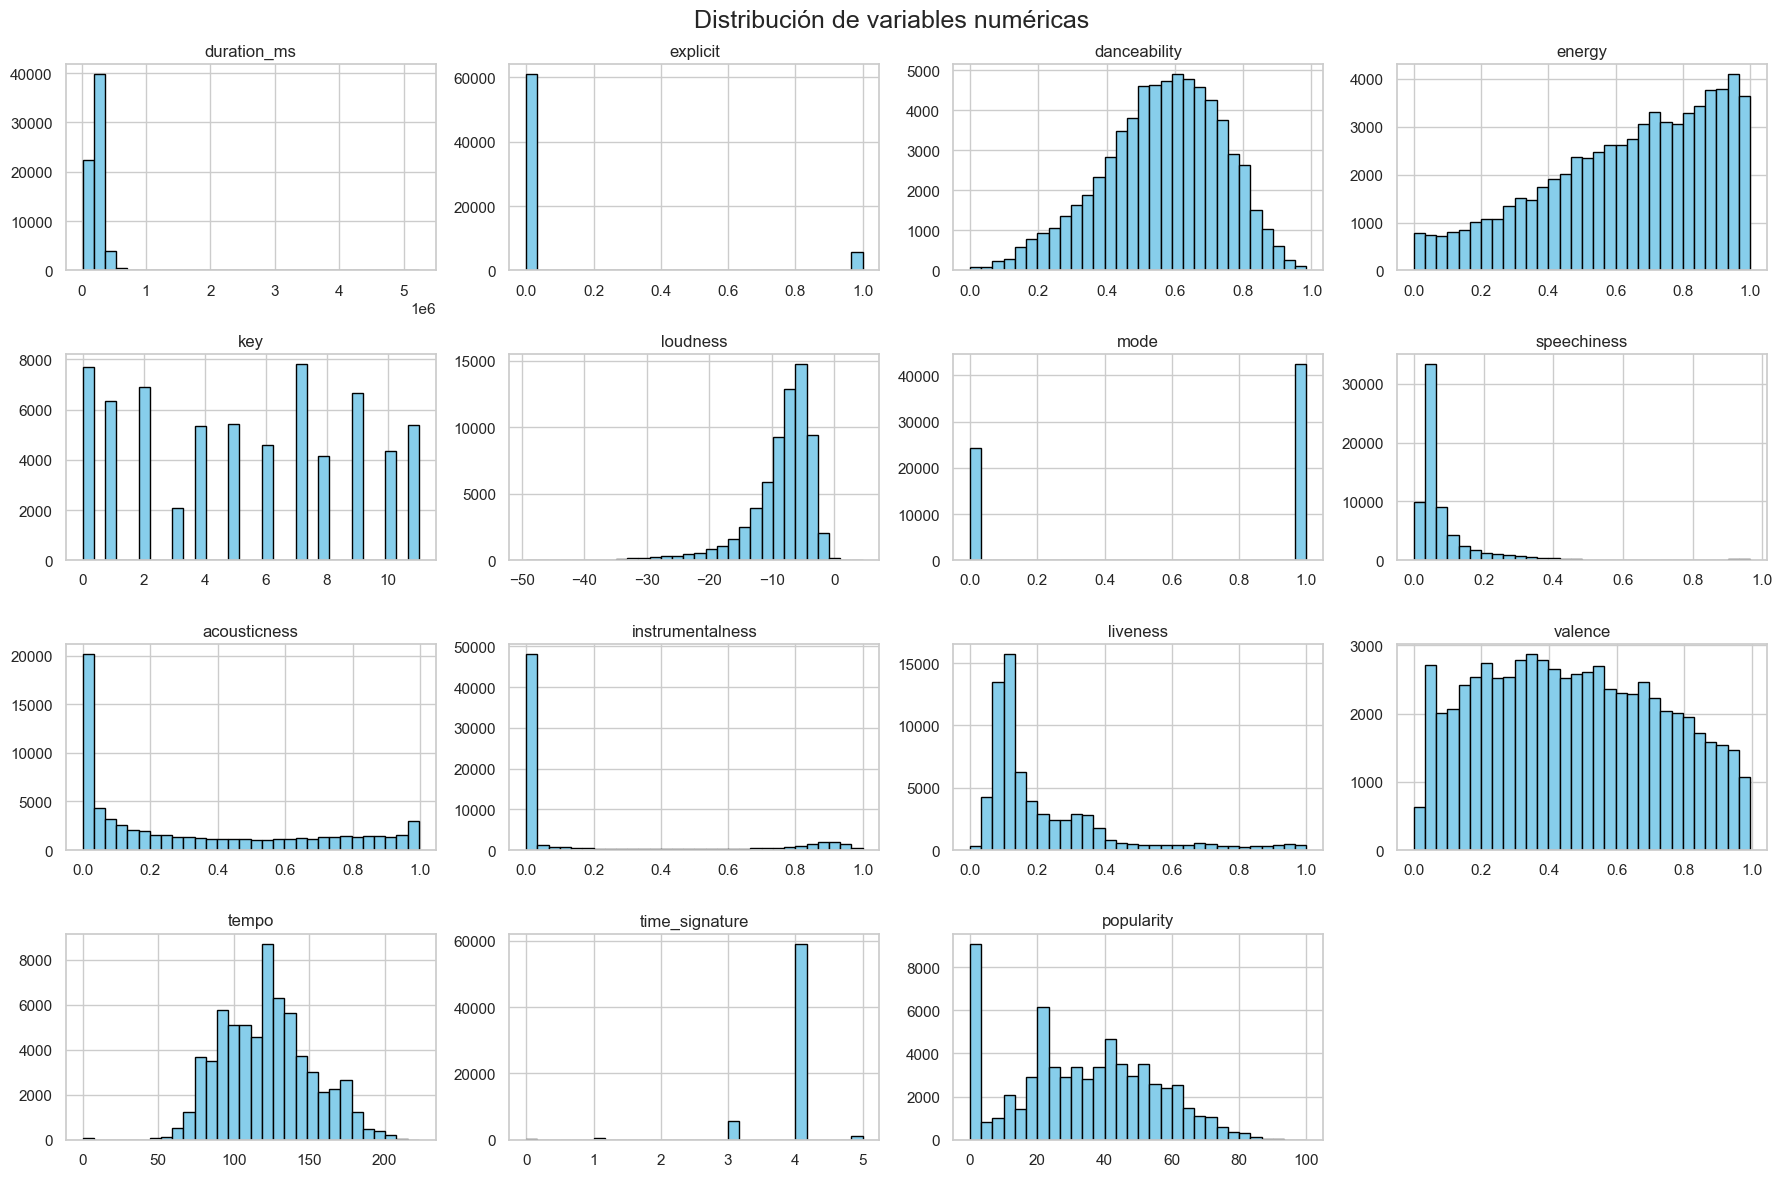

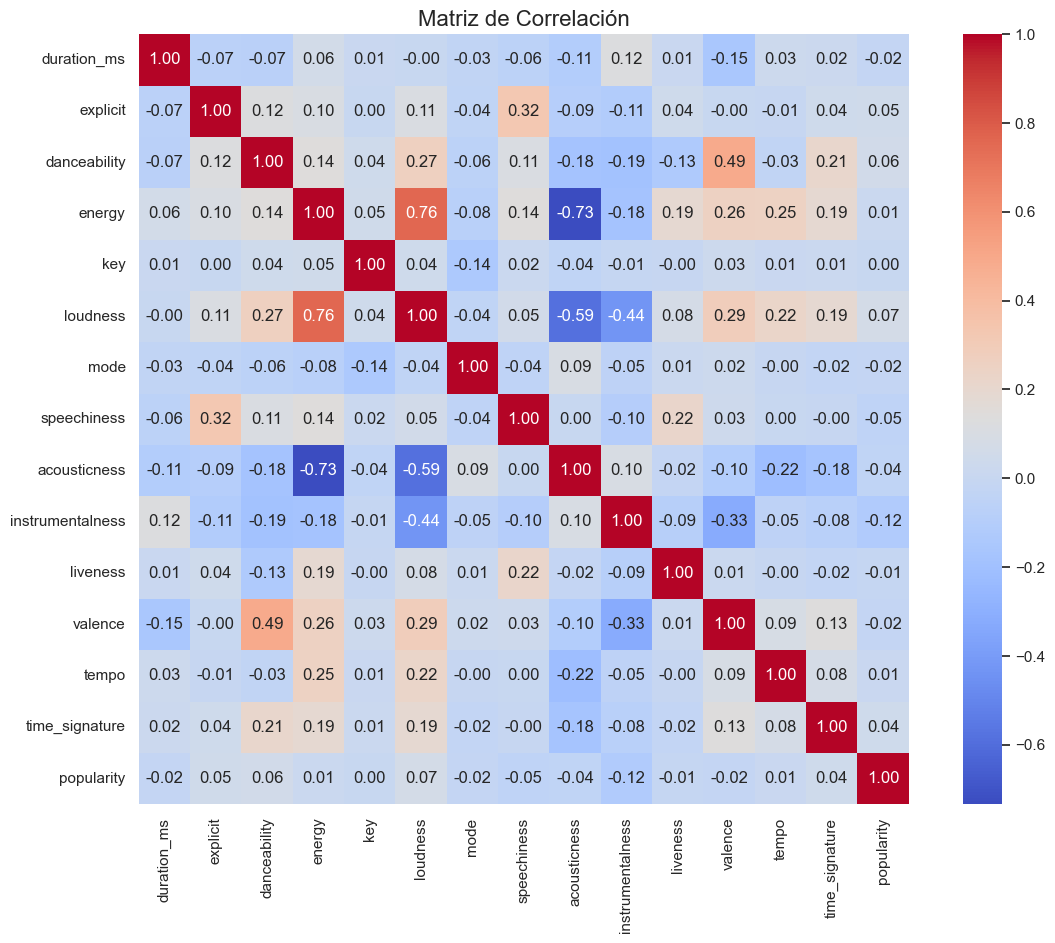

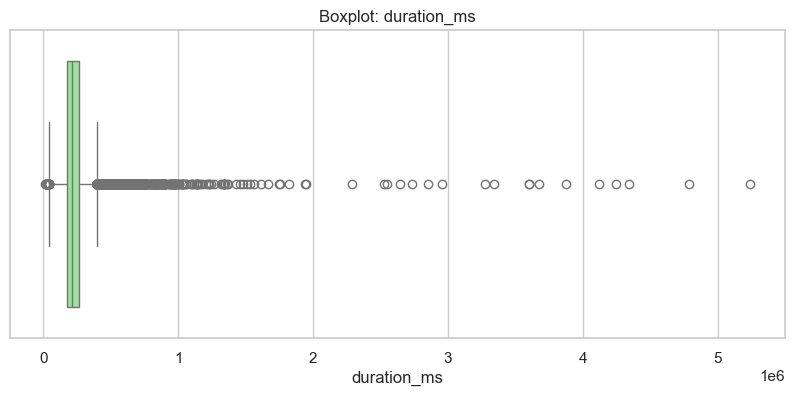

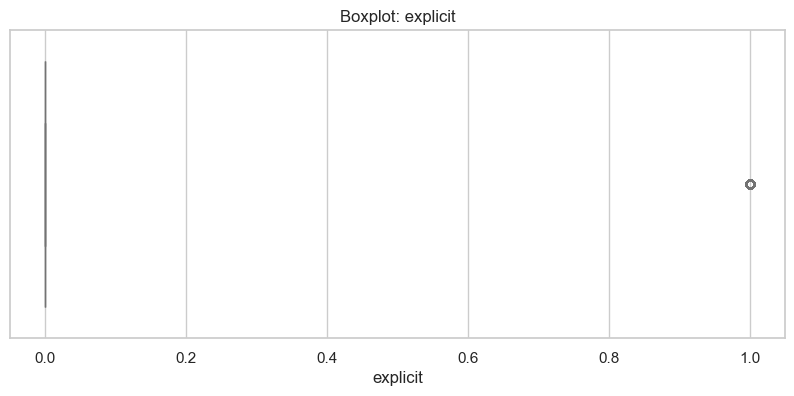

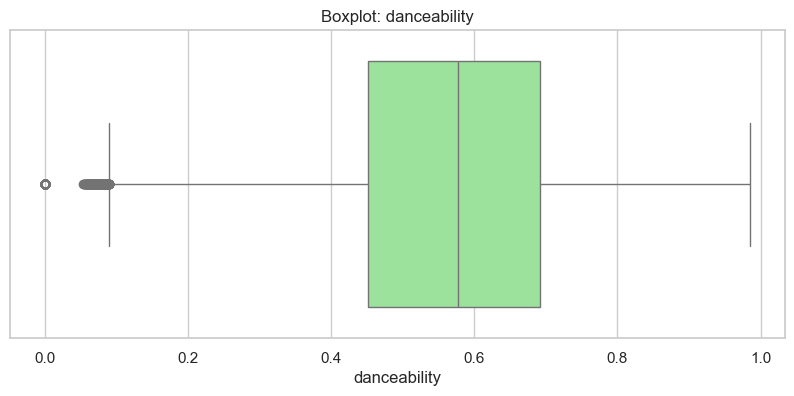

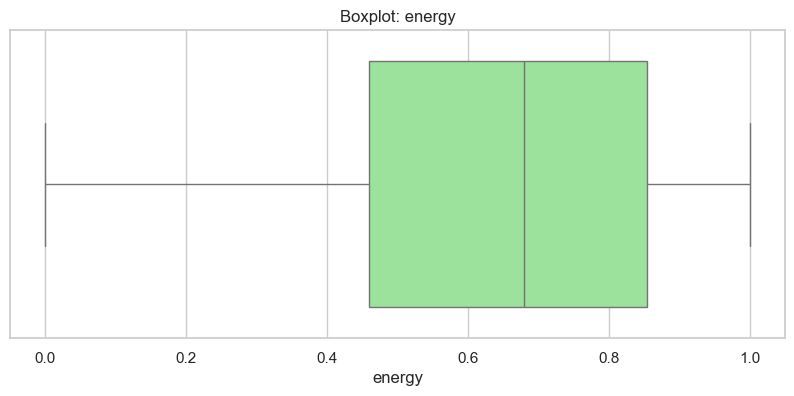

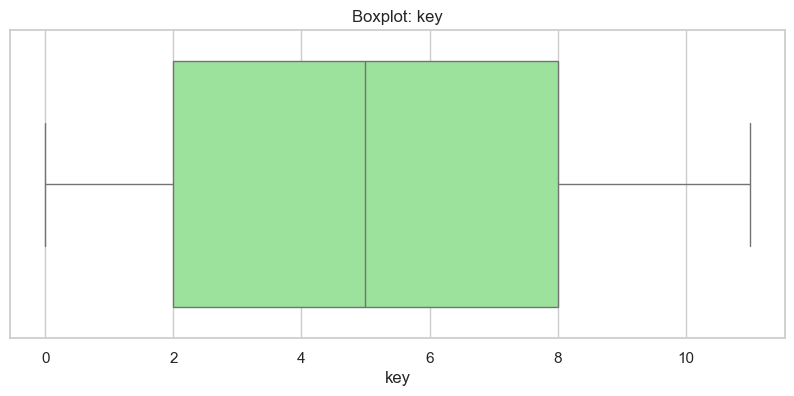

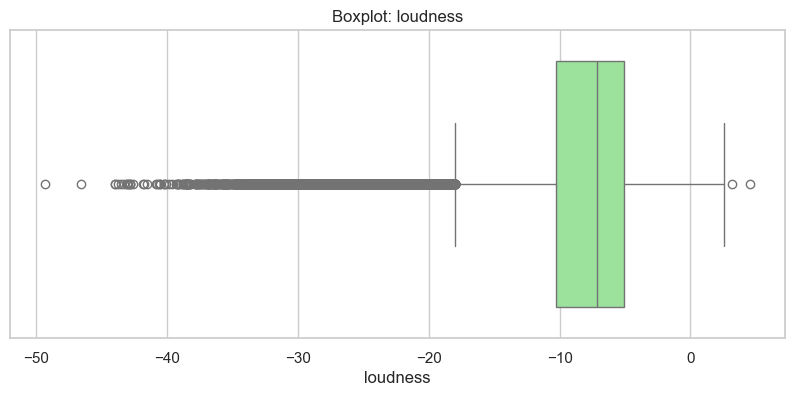

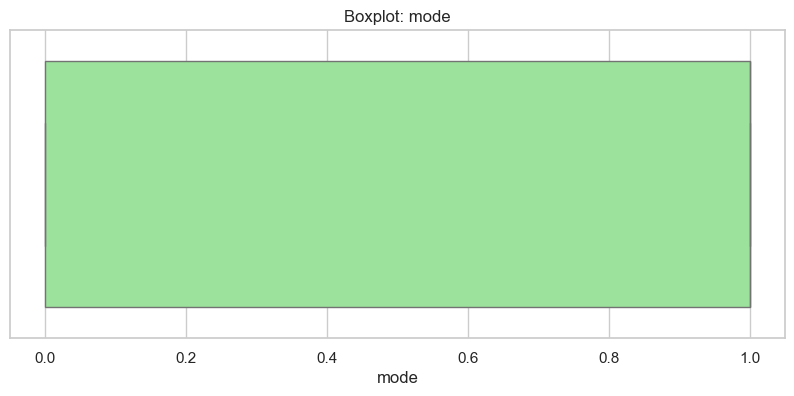

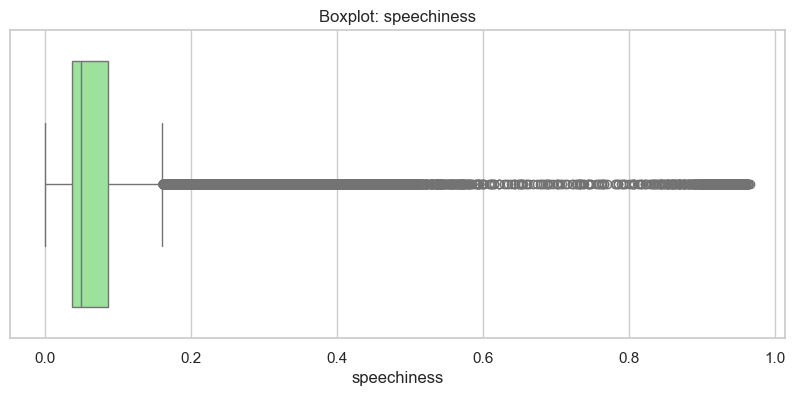

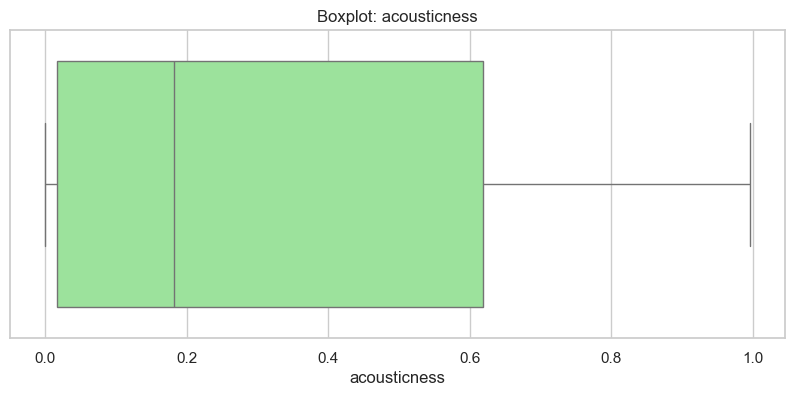

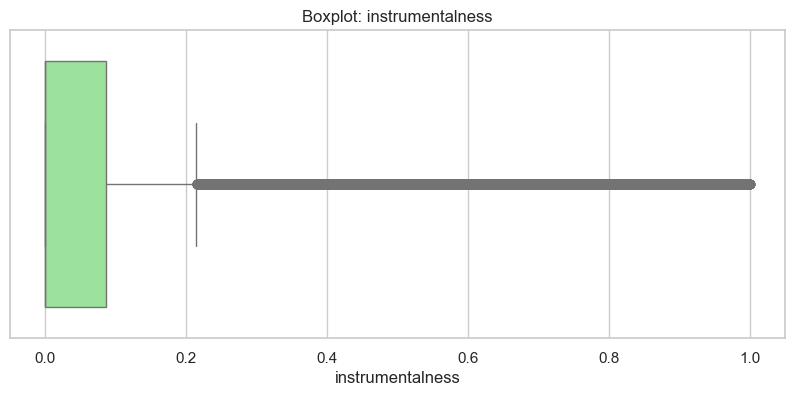

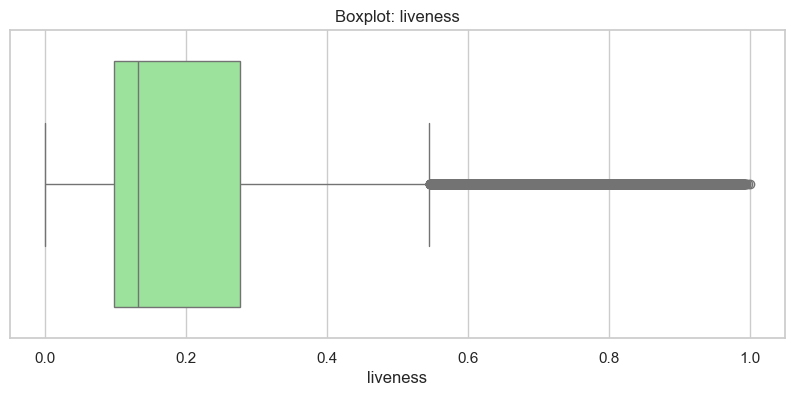

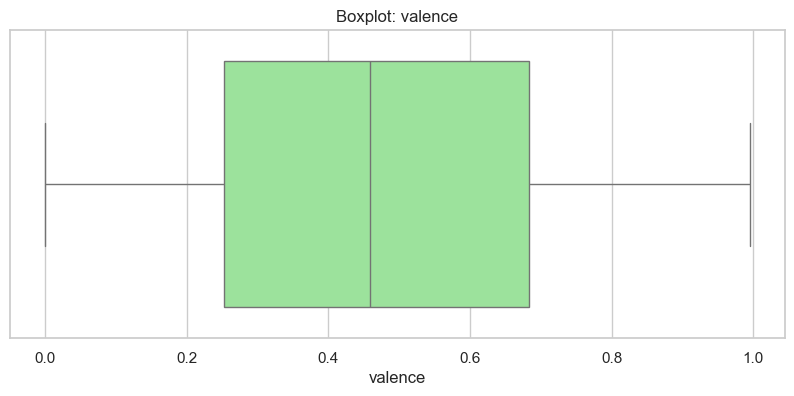

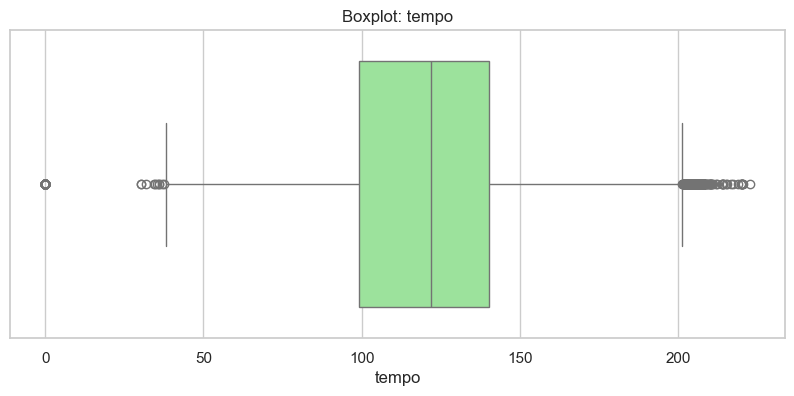

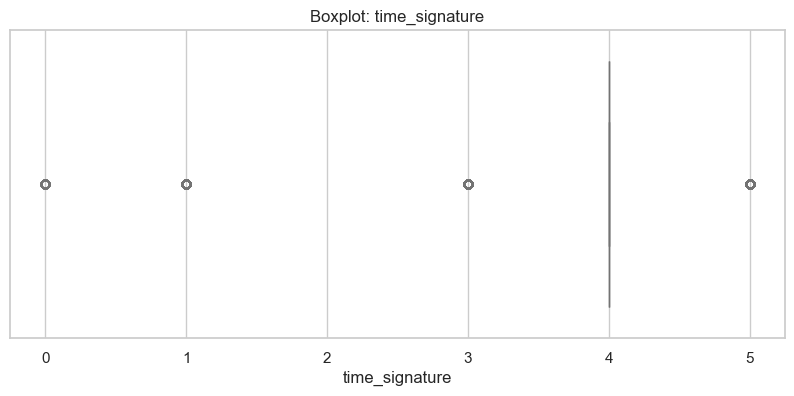

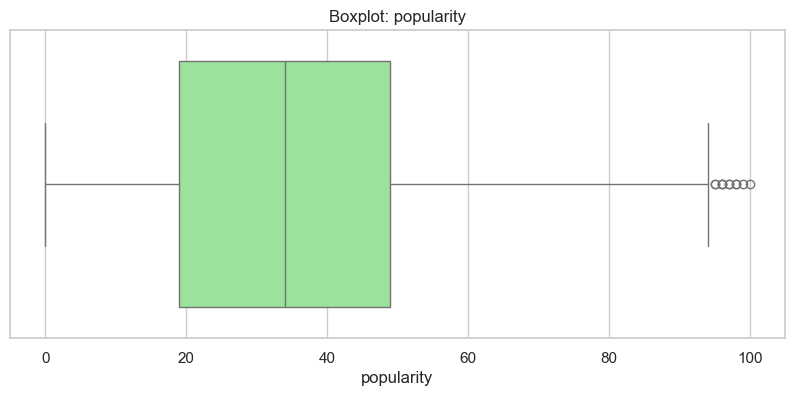

In [13]:
# Librerías necesarias
import matplotlib.pyplot as plt
import seaborn as sns

# Estilos de los gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# --- 1. Histograma de variables numéricas ---
dataTraining.select_dtypes(include=np.number).hist(bins=30, figsize=(18, 12), color='skyblue', edgecolor='black')
plt.suptitle("Distribución de variables numéricas", fontsize=18)
plt.tight_layout()
plt.show()

# --- 2. Mapa de calor de correlación ---
plt.figure(figsize=(14, 10))
corr = dataTraining.select_dtypes(include=np.number).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de Correlación", fontsize=16)
plt.show()

# --- 3. Boxplots para identificar outliers ---
for col in dataTraining.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=dataTraining[col], color='lightgreen')
    plt.title(f"Boxplot: {col}")
    plt.show()


In [14]:
# --- Variables categóricas ---
cat_cols = dataTraining.select_dtypes(include=['object','category']).columns.tolist()

# Visualizar la cantidad de valores únicos por variable categórica
print("Valores únicos por variable categórica:")
for col in cat_cols:
    print(f"{col}: {dataTraining[col].nunique()} valores únicos")

# --- 1. Distribución de frecuencia de las principales categorías ---
for col in cat_cols:
    if dataTraining[col].nunique() <= 50:  # Limita el análisis a columnas con un número manejable de categorías
        plt.figure(figsize=(10, 5))
        dataTraining[col].value_counts().head(20).plot(kind='bar', color='cornflowerblue')
        plt.title(f"Top 20 valores de {col}")
        plt.ylabel("Frecuencia")
        plt.xlabel(col)
        plt.xticks(rotation=45)
        plt.show()

# --- 2. Popularidad promedio por categoría ---
for col in cat_cols:
    if 'popularity' in dataTraining.columns and dataTraining[col].nunique() <= 50:
        popularity_by_cat = dataTraining.groupby(col)['popularity'].mean().sort_values(ascending=False).head(20)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=popularity_by_cat.values, y=popularity_by_cat.index, palette="viridis")
        plt.title(f"Popularidad promedio por {col} (Top 20)")
        plt.xlabel("Popularidad Promedio")
        plt.ylabel(col)
        plt.show()


Valores únicos por variable categórica:
track_id: 66720 valores únicos
artists: 25775 valores únicos
album_name: 37315 valores únicos
track_name: 55767 valores únicos
track_genre: 114 valores únicos


In [15]:
# Agrupar por 'track_genre' y calcular las medias de las columnas seleccionadas
perfil_generos = dataTraining.groupby('track_genre')[dataTraining.select_dtypes(include=np.number).columns].mean().round(2).sort_values('popularity', ascending=False)

# Mostrar el perfil
print(perfil_generos)

                duration_ms  explicit  danceability  energy   key  loudness  \
track_genre                                                                   
pop-film          282422.36      0.00          0.59    0.60  5.21     -7.89   
k-pop             256164.70      0.05          0.65    0.69  5.49     -6.32   
chill             171054.89      0.17          0.67    0.43  5.36    -10.29   
sad               154704.07      0.47          0.69    0.47  5.43    -10.11   
grunge            237209.52      0.07          0.45    0.80  5.22     -5.67   
...                     ...       ...           ...     ...   ...       ...   
chicago-house     358173.72      0.02          0.77    0.73  5.90     -9.19   
detroit-techno    370080.83      0.01          0.72    0.72  5.64    -11.03   
latin             210943.83      0.10          0.71    0.72  5.39     -5.26   
romance           203741.54      0.00          0.43    0.29  5.14    -13.15   
iranian           316229.52      0.07          0.30 

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

import category_encoders as ce

from scipy.stats import gaussian_kde

In [17]:
# modelo_2 = BaggingRegressor(
#     estimator=DecisionTreeRegressor(random_state=0),  # Árboles más regulados
#     n_estimators=100,              # Más árboles
#     random_state=0                 # Uso de todos los núcleos para acelerar
# )

# modelo_2 = XGBRegressor(
#     n_estimators=300,
#     max_depth=9,
#     learning_rate=0.2,
#     random_state=0
# )

modelo_2 = random_forest = RandomForestRegressor(
    n_estimators=100,
    max_depth=22,
    min_samples_split=2,
    min_samples_leaf=3,
    random_state=0
)

base_estimator = DecisionTreeRegressor(max_depth=22, min_samples_leaf=3, random_state=0)
modelo_1 = AdaBoostRegressor(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=0.5,
    random_state=0
)

# La variable de segmentación
segment_col = 'tempo'

# Definir el umbral o rangos de segmentación
def segment_selector(x):
    if x < 70:
        return 'Bajo'
    elif x < 180:
        return 'Medio'
    else:
        return 'Alto'

# Crear una copia del conjunto de prueba
df = dataTraining.copy()
categorical_cols = df.select_dtypes(include=['object','category']).columns

# Aplicar segmentación
df['segmento'] = df[segment_col].apply(segment_selector)

X = df.drop(columns=['popularity'])
y = df['popularity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

encoder = ce.TargetEncoder(cols=categorical_cols)
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)

X_train_encoded.drop(columns=['speechiness', 'energy', 'valence', 'duration_ms', 'artists', 'liveness', 'time_signature', 'mode', 'explicit'], inplace=True)
X_test_encoded.drop(columns=['speechiness', 'energy', 'valence', 'duration_ms', 'artists', 'liveness', 'time_signature', 'mode', 'explicit'], inplace=True)

X_train.drop(columns=['track_id', 'track_genre', 'track_name', 'artists', 'album_name'], inplace=True)
X_test.drop(columns=['track_id', 'track_genre', 'track_name', 'artists', 'album_name'], inplace=True)


In [18]:
# Inicializar vector de predicciones
y_pred_final = np.zeros(len(X_test))

# Asumimos que ya tenés y_test con los índices alineados
# Recorremos por segmento y aplicamos el modelo correspondiente
for segmento, modelo in [('Bajo', modelo_1), ('Alto', modelo_1), ('Medio', modelo_2)]:
    
    if segmento == 'Medio':
        X_mod = X_train
        X_mod_test = X_test
        #y_train = y_train
    else:
        X_mod = X_test_encoded
        X_mod_test = X_test_encoded
        #y_train = y_test

    mask = X_mod_test['segmento'] == segmento
    if mask.any():
        X_seg = X_mod_test[mask].drop(columns='segmento')
        y_seg = y_test.loc[X_seg.index]

        if segmento == 'Medio':
            kde = gaussian_kde(X_seg.T.values)
            probability_density = kde(X_seg.T.values)
            sample_weights = 1 / (probability_density)
            modelo.fit(X_seg, y_seg, sample_weight=sample_weights)
            preds = modelo.predict(X_seg)
            y_pred_final[mask] = preds

        else:
            modelo.fit(X_seg, y_seg)
            preds = modelo.predict(X_seg)
            y_pred_final[mask] = preds

# Convertir las predicciones a DataFrame (opcional)
y_pred_df = pd.DataFrame(y_pred_final, index=X_test.index, columns=['Predicciones'])
y_pred_df.head()


,Predicciones
78574,19.510150
64780,45.711356
78018,38.716221
61788,22.278276
31024,38.765707


Mean Squared Error (MSE): 157.4227
Root Mean Squared Error (RMSE): 12.5468
R-squared (R²): 0.6449


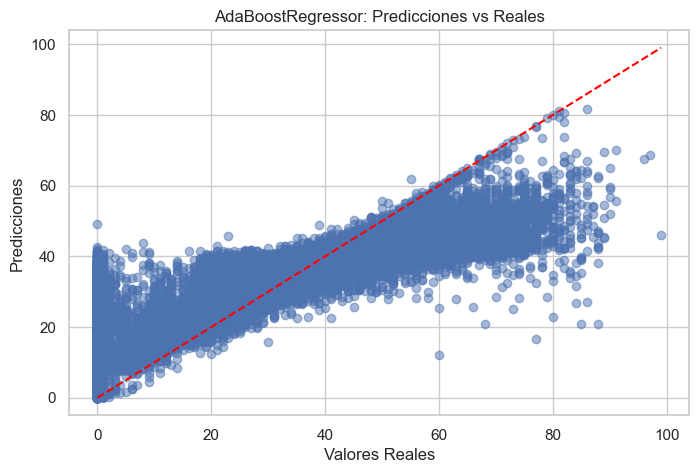

In [19]:
mse = mean_squared_error(y_test, y_pred_df)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_df)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_df, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("AdaBoostRegressor: Predicciones vs Reales")
plt.grid(True)
plt.show()

In [20]:
dataTesting['segmento'] = dataTesting['tempo'].apply(segment_selector)

dataTesting_encoder = encoder.transform(dataTesting)

dataTesting_encoder.drop(columns=['speechiness', 'energy', 'valence', 'duration_ms', 'artists', 'liveness', 'time_signature', 'mode', 'explicit'], inplace=True)
dataTesting.drop(columns=['track_id', 'track_genre', 'track_name', 'artists', 'album_name'], inplace=True)


In [21]:
y_pred_test_final = np.zeros(len(dataTesting))

for seg, modelo in [('Bajo', modelo_1), ('Alto', modelo_1), ('Medio', modelo_2)]:
    
    if seg == 'Medio':
        X_mod = dataTesting
    else:
        X_mod = dataTesting_encoder

    mask = X_mod['segmento'] == seg
    if mask.any():
        X_test_segmentado = X_mod.loc[mask].drop(columns='segmento')

        if segmento == 'Medio':
            numeric_columns = X_test_segmentado.select_dtypes(include=[np.number]).T.values
            kde = gaussian_kde(numeric_columns)
            probability_density = kde(numeric_columns)
            sample_weights = 1 / (probability_density)
            preds = modelo.predict(X_test_segmentado)
            y_pred_test_final[mask] = preds

        else:
            preds = modelo.predict(X_test_segmentado)
            y_pred_test_final[mask] = preds

pred_df = pd.DataFrame(y_pred_test_final, index=dataTesting.index, columns=['Popularity'])
pred_df.to_csv('test_submission_file.csv', index_label='ID')

pred_df.head()


,Popularity
0,42.953333
1,21.965416
2,31.289372
3,11.856010
4,36.714690
